In [1]:
# Recreation of James Rawlings example using pyomo parest
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/batch_data_solution.m

In [2]:
# Import libraries
from pyomo.environ import *
from pyomo.dae import *
import pyomo.contrib.parmest.parmest as parmest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_df = pd.read_csv("batch_data.csv")
data_df.head()

,t,ca
0,0,0.83
1,4,0.68
2,8,0.59
3,12,0.51
4,16,0.43


In [4]:
# Convert data to a list of dictionaries
data = [{'ca_meas': {k:v for (k, v) in zip(data_df.t, data_df.ca)}}]

In [13]:
#
# Define the model 
#
def batch_model(data):
    
    ca_meas = data['ca_meas']
    
    meas_t = list(ca_meas.keys())
        
    m = ConcreteModel()
    
    m.k1 = Var(initialize = 0.5, bounds = (1e-3, 3))
    m.n = Var(initialize = 1.0, bounds = (1e-3, 3))
    m.ca0 = Var(initialize = 0.8, bounds = (0.75, 0.9))
    
    m.time = ContinuousSet(bounds = (0.0, 40.0), initialize = meas_t)
    m.ca = Var(m.time, initialize = 0.8, bounds = (0, 0.9))
    
    m.dca = DerivativeVar(m.ca, wrt = m.time)
    
    def _dcarate(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dca[t] == -m.k1 * m.ca[t] ** m.n
    m.dcarate = Constraint(m.time, rule = _dcarate)
        
    def _initcon(m):
        return m.ca[m.time.first()] == m.ca0
    m.initcon = Constraint(rule = _initcon)
    
    def ComputeFirstStageCost_rule(m):
        return 0
    m.FirstStageCost = Expression(rule=ComputeFirstStageCost_rule)

    def ComputeSecondStageCost_rule(m):
        return sum((m.ca[t] - ca_meas[t]) ** 2 for t in meas_t) 
    m.SecondStageCost = Expression(rule=ComputeSecondStageCost_rule)

    
    def total_cost_rule(model):
        return model.FirstStageCost + model.SecondStageCost
    m.Total_Cost_Objective = Objective(rule=total_cost_rule, sense=minimize)
    
    disc = TransformationFactory('dae.collocation')
    disc.apply_to(m, nfe=20, ncp=4)
    
    #disc = TransformationFactory('dae.finite_difference')
    #disc.apply_to(m, nfe=500, scheme = 'BACKWARD')
    
    return m

In [14]:
# parameters to be estimated
theta_names = ['k1', 'n', 'ca0']

In [15]:
pest = parmest.Estimator(batch_model, data, theta_names, tee = True)

In [16]:
obj, theta = pest.theta_est()

Ipopt 3.11.1: max_iter=6000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      808
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      243

Total number of variables............................:      167
                     variables with only lower bounds:        0
                variables with lower and upper bou

In [17]:
# Estimated parameters
theta

{'ca0': 0.8260128525831442, 'k1': 0.05046635330455565, 'n': 1.439807357294396}

In [18]:
# Get ca, cb, cc profiles with estimated parameters
ms = batch_model(data[0])
ms.k1.fix(theta['k1'])
ms.n.fix(theta['n'])
ms.ca0.fix(theta['ca0'])
solver = SolverFactory('ipopt')
solver.solve(ms, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      641
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       81

Total number of variables............................:      161
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       81


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 161, 'Number of variables': 161, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.05318903923034668}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

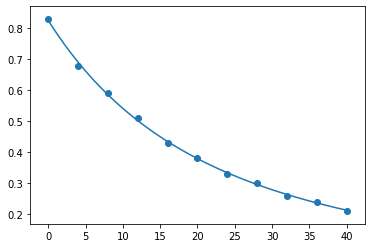

In [19]:
fig, ax = plt.subplots()
ax.plot(list(ms.time), [ms.ca[t]() for t in ms.time])
ax.scatter(data[0]['ca_meas'].keys(), data[0]['ca_meas'].values())